very loosely based on https://keras.io/examples/vision/mnist_convnet/

In [ ]:
outdim=10

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
bx_train = np.expand_dims(x_train, -1)
bx_test = np.expand_dims(x_test, -1)
print("x_train shape:", bx_train.shape)
print(bx_train.shape[0], "train samples")
print(bx_test.shape[0], "test samples")


# convert class vectors to binary class matrices
by_train = keras.utils.to_categorical(y_train, num_classes)
by_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
classes=[0,1]
x_train=np.array(
    [xx for xx,yy in zip(bx_train,by_train) if
      np.any([yy[cc] for cc in classes])
    ])
y_train=np.array([yy for yy in by_train if np.any([yy[cc] for cc in classes])])
print(x_train.shape)
print(y_train.shape)

xa_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      not np.any([yy[cc] for cc in classes])
    ])
ya_test=np.array([yy for yy in by_test if not np.any([yy[cc] for cc in classes])])
print(xa_test.shape)
print(ya_test.shape)
xn_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      np.any([yy[cc] for cc in classes])
    ])
yn_test=np.array([yy for yy in by_test if np.any([yy[cc] for cc in classes])])
print(xn_test.shape)
print(yn_test.shape)



(12665, 28, 28, 1)
(12665, 10)
(7885, 28, 28, 1)
(7885, 10)
(2115, 28, 28, 1)
(2115, 10)


In [ ]:
def loss(outdim):
    if outdim==1:
        def lss(a,b):
            q=b
            return K.mean((q-1)**2)
        return lss
    def lss(a,b):
        q=b
        pd=[i for i in range(len(q.shape))]
        pd.remove(pd[-1])
        pd.insert(0,len(pd))
        #print(pd)
        q=K.permute_dimensions(q,tuple(pd))
        #exit()

        #print(q.shape)

        adl=None

        for i in range(outdim):
            for j in range(i+1,outdim):
              ac=K.abs(K.mean(((q[i]-1)*(q[j]-1))))
              if adl is None:
                  adl=ac
              else:
                  adl+=ac

        return adl
    return lss

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(7, 7), activation="relu",use_bias=False),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(4, 4), activation="relu",use_bias=False),
        layers.Conv2D(16, kernel_size=(4, 4), activation="relu",use_bias=False),
        layers.Conv2D(4, kernel_size=(2, 2), activation="relu",use_bias=False),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(4,kernel_size=(1,1),activation="linear",padding="same",use_bias=False),
        layers.Flatten(),
        layers.Dense(outdim,use_bias=False)
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          32768     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 16)          16384     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 4)           256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 4)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 4)           1

In [ ]:
batch_size = 128
epochs = 5

model.compile(loss=loss(outdim), optimizer="adam", metrics=[])

model.fit(x_train,
          np.ones_like(x_train),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Epoch 1/5
90/90 [==============================] - 17s 139ms/step - loss: 5.7754 - val_loss: 0.7279
Epoch 2/5
90/90 [==============================] - 12s 130ms/step - loss: 0.2804 - val_loss: 0.2665
Epoch 3/5
90/90 [==============================] - 12s 128ms/step - loss: 0.1186 - val_loss: 0.1535
Epoch 4/5
90/90 [==============================] - 12s 129ms/step - loss: 0.0648 - val_loss: 0.0647
Epoch 5/5
90/90 [==============================] - 12s 128ms/step - loss: 0.0352 - val_loss: 0.0292


In [ ]:
pa=model.predict(xa_test)
pn=model.predict(xn_test)

In [ ]:
print(pa.shape)
print(pn.shape)

(7885, 10)
(2115, 10)


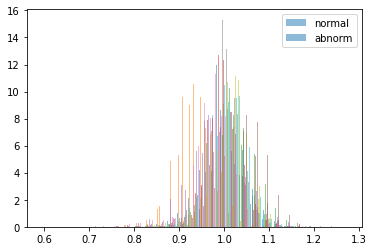

In [ ]:
import matplotlib.pyplot as plt
plt.hist(pn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(pa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

In [ ]:
def dexbyloss(lss):return np.argmin(np.mean((pn-lss)**2,axis=1))
minl=np.min(pn,axis=0)
maxl=np.max(pn,axis=0)
print(minl,maxl)
ls=[np.arange(aminl,amaxl,(amaxl-aminl)/9.0001) for aminl,amaxl in zip(minl,maxl)]
print(minl,ls,maxl)
print(len(ls))

[0.78230304 0.640278   0.7470581  0.766986   0.59240264 0.71408063
 0.64362425 0.7033523  0.67650837 0.745955  ] [1.1733088 1.1117902 1.2126875 1.1937423 1.1968154 1.2353951 1.1707721
 1.1548833 1.1603166 1.1644418]
[0.78230304 0.640278   0.7470581  0.766986   0.59240264 0.71408063
 0.64362425 0.7033523  0.67650837 0.745955  ] [array([0.78230304, 0.82574764, 0.86919225, 0.91263686, 0.95608147,
       0.99952607, 1.04297068, 1.08641529, 1.1298599 , 1.1733045 ]), array([0.64027798, 0.69266764, 0.74505731, 0.79744697, 0.84983663,
       0.90222629, 0.95461595, 1.00700562, 1.05939528, 1.11178494]), array([0.74705809, 0.79879412, 0.85053014, 0.90226617, 0.95400219,
       1.00573822, 1.05747424, 1.10921027, 1.16094629, 1.21268232]), array([0.76698601, 0.81440285, 0.86181968, 0.90923652, 0.95665336,
       1.00407019, 1.05148703, 1.09890386, 1.1463207 , 1.19373753]), array([0.59240264, 0.65955886, 0.72671509, 0.79387131, 0.86102753,
       0.92818376, 0.99533998, 1.06249621, 1.12965243, 1.19

In [ ]:
def moduloop(q,modulo=1):
  i,j=0,0
  while True:
    yield q[i]
    j+=1
    if not (j%modulo):
      i+=1
      i=i%len(q)

def allcomb(q):
  modulo=1
  iterators=[]
  for zw in q:
    iterators.append(moduloop(zw,modulo))
    modulo*=len(zw)
  for i in range(modulo):
      yield [zw.__next__() for zw in iterators]


In [ ]:
from tqdm import tqdm
bids=[[0,1,2,3,4,5,6,7,8,9] for zw in ls]




x,y=[],[]

for bid,lss in tqdm(zip(allcomb(bids),allcomb(ls)),total=10**outdim):
  x.append(bid)
  y.append(dexbyloss(lss))

x=np.array(x)
y=np.array(y)

cls=np.array([np.argmax(yn_test[yy]) for yy in tqdm(y,total=10**outdim)])

print(x.shape,y.shape,cls.shape)



  0%|          | 95278/10000000000 [00:14<411:49:38, 6744.94it/s]

KeyboardInterrupt: ignored

In [ ]:
for dim in range(outdim):
  mns,stds=[],[]
  for val in range(10):
    dex=np.where(x[:,dim]==val)
    vals=cls[dex]
    mn=np.mean(vals)
    std=np.std(vals)/np.sqrt(len(vals))
    mns.append(mn)
    stds.append(std)
    #print(f"x{dim}={val}:{mn}+-{std}")
  plt.errorbar(range(10),mns,yerr=stds,label=dim,alpha=0.6)
plt.legend()
plt.show()

In [ ]:
p=model.predict(x_train)


In [ ]:
mp=np.mean(p,axis=0)
da=np.abs(pa-mp)
dn=np.abs(pn-mp)
dfa=np.sqrt(np.mean(da**2,axis=1))
dfn=np.sqrt(np.mean(dn**2,axis=1))
print(dfa.shape,dfn.shape)

(7885,) (2115,)


In [ ]:
print("normal",np.mean(dfn),np.std(dfn))
print("abnorm",np.mean(dfa),np.std(dfa))

normal 0.03874363 0.020849748
abnorm 0.044746097 0.021427866


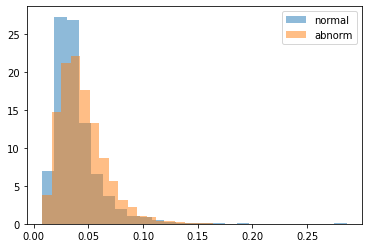

In [ ]:
plt.hist(dfn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(dfa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

In [ ]:
y_score=np.concatenate((dfn,dfa),axis=0)
y_true=np.concatenate((np.zeros_like(dfn),np.ones_like(dfa)),axis=0)

print(y_true.shape,y_score.shape)

(10000,) (10000,)


In [ ]:
from sklearn.metrics import roc_auc_score as rauc

auc=rauc(y_true,y_score)
print(auc)

0.602185254643059
